### Add Packages

In [7]:
using JLD2
# using PythonPlot
include("MDPModelFunctions2.jl")
using DataFrames
using ImageFiltering
include("setupPythonPlot.jl")
# using PyCall

"none"

#### Functions to load results from run

In [8]:

function load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    if on_cluster
        to_save_folder = "/home/erussek/projects/Memory_Models/shimi_all_parameter_search_fine2_2"
    else
        to_save_folder = "/Users/erussek/Dropbox/Griffiths_Lab_Stuff/Data/Memory_Models/shimi_all_parameter_search_fine2_b1/exp$(exp_num)"
    end
    
    local file_name = "N_Quanta_$(N_Quanta)_epsilon_$(epsilon)_NT_per_Second_$(NT_per_Second)_memslope_$(mem_slope).jld2"
    
    local full_file_path = joinpath(to_save_folder,file_name)

    res = load(full_file_path)
    
    return res["job_res_$(exp_num)"]
end

function format_res_cowan_k(res; exp_num = 1)
    
    if exp_num == 1
    
        # row is 2 obj vs 4 obj
        # col is pre-cue, neutral, retro-cue, neutral
        
        part_pcorr = res[:,:,end];
        model_cowan_p_corr = [part_pcorr; part_pcorr[2,:]']'
        model_cowan_k_mtx = cowan_k(model_cowan_p_corr, 2)
        model_cowan_k_mtx[2,:] = cowan_k(model_cowan_p_corr[2,:], 4)
        
        model_cowan_k = [model_cowan_k_mtx[1,:]' model_cowan_k_mtx[2,:]']';#[model_cowan_k_mtx[1,:] model_cowan_k_mtx[2,:]]
    elseif exp_num == 2
        
        # IM cued, IM neutral, VSTM cued, VSTM neutral - need to adjust from what it was saved as
        
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = res
        (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = (p_short_neutral[end], p_short_retro[end], p_long_neutral[end], p_long_retro[end])
        model_cowan_k = cowan_k([p_short_retro p_short_neutral p_long_retro p_long_neutral],4)'
        
    else
        
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = res
        (p_IM_neutral, p_IM_retro, p_VSTM_neutral, p_VSTM_retro, p_Long_VSTM_neutral, p_Long_VSTM_retro) = (p_IM_neutral[:,end], p_IM_retro[:,end], p_VSTM_neutral[:,end], p_VSTM_retro[:,end], p_Long_VSTM_neutral[:,end], p_Long_VSTM_retro[:,end])


        # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
        IM_model = [cowan_k(p_IM_retro[1],3) cowan_k(p_IM_neutral[1],3) cowan_k(p_IM_retro[2],6) cowan_k(p_IM_neutral[2], 6)]
        Short_VSTM_model = [cowan_k(p_VSTM_retro[1],3) cowan_k(p_VSTM_neutral[1],3) cowan_k(p_VSTM_retro[2],6) cowan_k(p_VSTM_neutral[2], 6)]
        Long_VSTM_model = [cowan_k(p_Long_VSTM_retro[1],3) cowan_k(p_Long_VSTM_neutral[1],3) cowan_k(p_Long_VSTM_retro[2],6) cowan_k(p_Long_VSTM_neutral[2], 6)]

        # 3 x 4
        model_cowan_k = [IM_model; Short_VSTM_model; Long_VSTM_model]  
        
    end
        
    return model_cowan_k
    
end    

function load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    
    res = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)
    
    model_cowan_k = format_res_cowan_k(res; exp_num = exp_num)
    
    return model_cowan_k
    
end


load_cowan_k (generic function with 1 method)

#### Specify run parameters

In [9]:
## Specify parameters for each job and load all results...

eps_vals = collect(1:-.02:.02) # 17
c_vals = round.(1 .- eps_vals, digits = 2)
N_eps = length(eps_vals)

# quanta values
q_vals = collect(2:1:50)
N_q = length(q_vals)

mem_slopes = [.2]
N_ms = length(mem_slopes)

# re-run with new values so we can see some concavity...
NT_vals = [800] # run w these now... 
N_nt = length(NT_vals)

N_hyp = N_nt

1

### Compute for each parameter combination, MSE from real data
Specify real data values

In [10]:
# experiment 1....

# row is 2 obj vs 4 obj
# col is 2 pre-cue, 2 neutral, 2 retro-cue, 2 neutral, 4 pre-cue, 4 neutral, 4 retro-cue, 4 neutral

exp1_cowan_k_true_7_yr = [1.16 1.14 1.13 1.02 2.80 .91 1.30 .96]'
exp1_cowan_k_true_adult = [1.98 1.94 1.97 1.95 3.87 2.66 3.64 2.87]'

# experiment 2 - 4 objects
# col is IM cued, IM neutral, VSTM cued, VSTM neutral

exp2_cowan_k_true_7_yr = [1.55 1.16 1.00 0.69]'
exp2_cowan_k_true_adult = [3.54 2.58 3.58 2.65]'

# experiment 3

# Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral
IM_true_7_yr = [1.44 1.27 1.82 0.88]
Short_VSTM_true_7_yr = [1.14 0.77 NaN NaN]
Long_VSTM_true_7_yr = [1.19 0.90 NaN NaN]

exp3_cowan_k_true_7_yr = [IM_true_7_yr; Short_VSTM_true_7_yr; Short_VSTM_true_7_yr]


IM_true_adult = [2.63 2.41 4.80 2.46]
Short_VSTM_true_adult = [2.75 2.38 3.97 2.15]
Long_VSTM_true_adult = [2.76 2.30 3.65 1.75]

exp3_cowan_k_true_adult = [IM_true_adult; Short_VSTM_true_adult; Short_VSTM_true_adult];


### Get mean squared error for each parameter value, for each experiment, for child and adult separately

In [11]:
mse_res = Dict()
for exp_num in 1:3
    mse_res[exp_num] = Dict()
    mse_res[exp_num]["child"] = zeros(N_eps, N_q)
    mse_res[exp_num]["adult"] = zeros(N_eps, N_q)
end

for (ep_idx, epsilon) in enumerate(eps_vals)
    for (q_idx, N_Quanta) in enumerate(q_vals)
        for hyp_idx in 1:length(mem_slopes)
            
            NT_per_Second = NT_vals[hyp_idx]
            mem_slope = mem_slopes[hyp_idx]


            for exp_num = 1:3

                #try

                    model_cowan_k = load_cowan_k(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = exp_num, on_cluster = false)

                    if exp_num == 1

                        child_mse = sum((model_cowan_k .- exp1_cowan_k_true_7_yr).^2)
                        adult_mse = sum((model_cowan_k .- exp1_cowan_k_true_adult).^2)

                    elseif exp_num == 2

                        child_mse = sum((model_cowan_k .- exp2_cowan_k_true_7_yr).^2)
                        adult_mse = sum((model_cowan_k .- exp2_cowan_k_true_adult).^2)

                    else

                        child_sq_err = (model_cowan_k[:] .- exp3_cowan_k_true_7_yr[:]).^2
                        child_mse = sum(child_sq_err[.!isnan.(child_sq_err)])
                        adult_mse = sum((model_cowan_k .- exp3_cowan_k_true_adult).^2)

                    end

                    mse_res[exp_num]["child"][ep_idx, q_idx] = child_mse
                    mse_res[exp_num]["adult"][ep_idx, q_idx] = adult_mse

                #catch

                    #print("$(exp_num), $(epsilon), $(N_Quanta), $(NT_per_Second), $(mem_slope)")

                    #mse_res[exp_num]["child"][ep_idx, q_idx] = NaN
                    #mse_res[exp_num]["adult"][ep_idx, q_idx] = NaN
                #end
            end
        end
    end
end

# aggregate accross experiments
child_mse_all =  mse_res[1]["child"] + mse_res[2]["child"] + mse_res[3]["child"];
adult_mse_all =  mse_res[1]["adult"] + mse_res[2]["adult"] + mse_res[3]["adult"];

In [12]:
model_info = Dict()

smooth_image = false

######################
### Both Flex Model###
#######################

# first get best fitting param for when both are allowed to vary...
model_info["Both_Flex"] = Dict()

# child parameters
this_child_mse = child_mse_all

if smooth_image
    this_child_mse = imfilter(this_child_mse, Kernel.gaussian(1))
end

model_info["Both_Flex"]["Child_MSE"] = minimum(this_child_mse)
both_flex_child_pidx = argmin(this_child_mse)
model_info["Both_Flex"]["Child_Eps"] = eps_vals[both_flex_child_pidx[1]]
model_info["Both_Flex"]["Child_Q"] = Int(q_vals[both_flex_child_pidx[2]])

# adult parameters
this_adult_mse = adult_mse_all

if smooth_image
    this_adult_mse = imfilter(this_adult_mse, Kernel.gaussian(1))
end

model_info["Both_Flex"]["Adult_MSE"] = minimum(this_adult_mse)
both_flex_adult_pidx = argmin(this_adult_mse)
model_info["Both_Flex"]["Adult_Eps"] = eps_vals[both_flex_adult_pidx[1]]
model_info["Both_Flex"]["Adult_Q"] = Int(q_vals[both_flex_adult_pidx[2]]);
model_info["Both_Flex"]["Both_MSE"] = model_info["Both_Flex"]["Child_MSE"] + model_info["Both_Flex"]["Adult_MSE"];

##########################
### Fix Epsilon Model ####
#########################

model_info["Share_Eps"] = Dict()

best_mse_child_by_eps = zeros(N_eps)
best_mse_adult_by_eps = zeros(N_eps)
best_q_child_by_eps=zeros(N_eps)
best_q_adult_by_eps=zeros(N_eps)
best_q_idx_child_by_eps = zeros(N_eps)
best_q_idx_adult_by_eps = zeros(N_eps)

for eps_idx in 1:N_eps
    best_mse_child_by_eps[eps_idx] = minimum(this_child_mse[eps_idx,:])
    best_q_child_by_eps[eps_idx] = q_vals[argmin(this_child_mse[eps_idx,:])]
    best_q_idx_child_by_eps[eps_idx] = argmin(this_child_mse[eps_idx,:]);
    
    best_mse_adult_by_eps[eps_idx] = minimum(this_adult_mse[eps_idx,:])
    best_q_adult_by_eps[eps_idx] = q_vals[argmin(this_adult_mse[eps_idx,:])]
    best_q_idx_adult_by_eps[eps_idx] = argmin(this_adult_mse[eps_idx,:]);

end

best_mse_both_by_eps = best_mse_child_by_eps + best_mse_adult_by_eps
best_EPS_idx = argmin(best_mse_both_by_eps)
best_EPS = eps_vals[best_EPS_idx]

model_info["Share_Eps"]["Child_Eps"] = best_EPS
model_info["Share_Eps"]["Child_Q"] = best_q_child_by_eps[argmin(best_mse_both_by_eps)]

model_info["Share_Eps"]["Adult_Eps"] = best_EPS
model_info["Share_Eps"]["Adult_Q"] = best_q_adult_by_eps[argmin(best_mse_both_by_eps)]

model_info["Share_Eps"]["Child_MSE"] = this_child_mse[eps_vals .== model_info["Share_Eps"]["Child_Eps"], q_vals .== model_info["Share_Eps"]["Child_Q"]][1]
model_info["Share_Eps"]["Adult_MSE"] = this_adult_mse[eps_vals .== model_info["Share_Eps"]["Adult_Eps"], q_vals .== model_info["Share_Eps"]["Adult_Q"]][1]

model_info["Share_Eps"]["Both_MSE"] = model_info["Share_Eps"]["Child_MSE"] + model_info["Share_Eps"]["Adult_MSE"];

#########################
### Fix Quanta Model ###
########################

model_info["Share_Q"] = Dict()

best_mse_child_by_q = zeros(N_q)
best_mse_adult_by_q = zeros(N_q)
best_eps_child_by_q = zeros(N_q)
best_eps_adult_by_q = zeros(N_q)

for q_idx in 1:N_q
    best_mse_child_by_q[q_idx] = minimum(this_child_mse[:,q_idx])
    best_eps_child_by_q[q_idx] = eps_vals[argmin(this_child_mse[:,q_idx])]
    
    best_mse_adult_by_q[q_idx] = minimum(this_adult_mse[:,q_idx])
    best_eps_adult_by_q[q_idx] = eps_vals[argmin(this_adult_mse[:,q_idx])]
end

best_mse_both_by_q = best_mse_child_by_q + best_mse_adult_by_q
best_Q = q_vals[argmin(best_mse_both_by_q)]

model_info["Share_Q"]["Child_Eps"] = best_eps_child_by_q[argmin(best_mse_both_by_q)]
model_info["Share_Q"]["Child_Q"] = best_Q
model_info["Share_Q"]["Child_MSE"] = this_child_mse[eps_vals .== model_info["Share_Q"]["Child_Eps"], q_vals .== model_info["Share_Q"]["Child_Q"]][1]

model_info["Share_Q"]["Adult_Eps"] = best_eps_adult_by_q[argmin(best_mse_both_by_q)]
model_info["Share_Q"]["Adult_Q"] = best_Q;
model_info["Share_Q"]["Adult_MSE"] = this_adult_mse[eps_vals .== model_info["Share_Q"]["Adult_Eps"], q_vals .== model_info["Share_Q"]["Adult_Q"]][1]
model_info["Share_Q"]["Both_MSE"] = model_info["Share_Q"]["Child_MSE"] .+ model_info["Share_Q"]["Adult_MSE"]


#######################
## Fix Both Model ####
######################
model_info["Share_Both"] = Dict()
this_both_mse = this_child_mse + this_adult_mse

both_min_idx = argmin(this_both_mse)
both_eps_val = eps_vals[both_min_idx[1]]
both_q_val = q_vals[both_min_idx[2]]

model_info["Share_Both"]["Child_Eps"] = both_eps_val
model_info["Share_Both"]["Adult_Eps"] = both_eps_val
model_info["Share_Both"]["Child_Q"] = both_q_val
model_info["Share_Both"]["Adult_Q"] = both_q_val
model_info["Share_Both"]["Child_MSE"] = this_child_mse[both_min_idx]
model_info["Share_Both"]["Adult_MSE"] = this_adult_mse[both_min_idx];
model_info["Share_Both"]["Both_MSE"] = model_info["Share_Both"]["Child_MSE"] + model_info["Share_Both"]["Adult_MSE"];



In [13]:
model_info["Both_Flex"]

Dict{Any, Any} with 7 entries:
  "Child_Eps" => 0.62
  "Child_Q"   => 9
  "Child_MSE" => 0.526693
  "Adult_MSE" => 1.02517
  "Adult_Q"   => 24
  "Adult_Eps" => 0.7
  "Both_MSE"  => 1.55186

### Get best fitting parameters for 3 types of models
1: Best fit parameters for both
2: Epsilon fixed, quanta vary,
3: Quanta fixed, epsilon vary

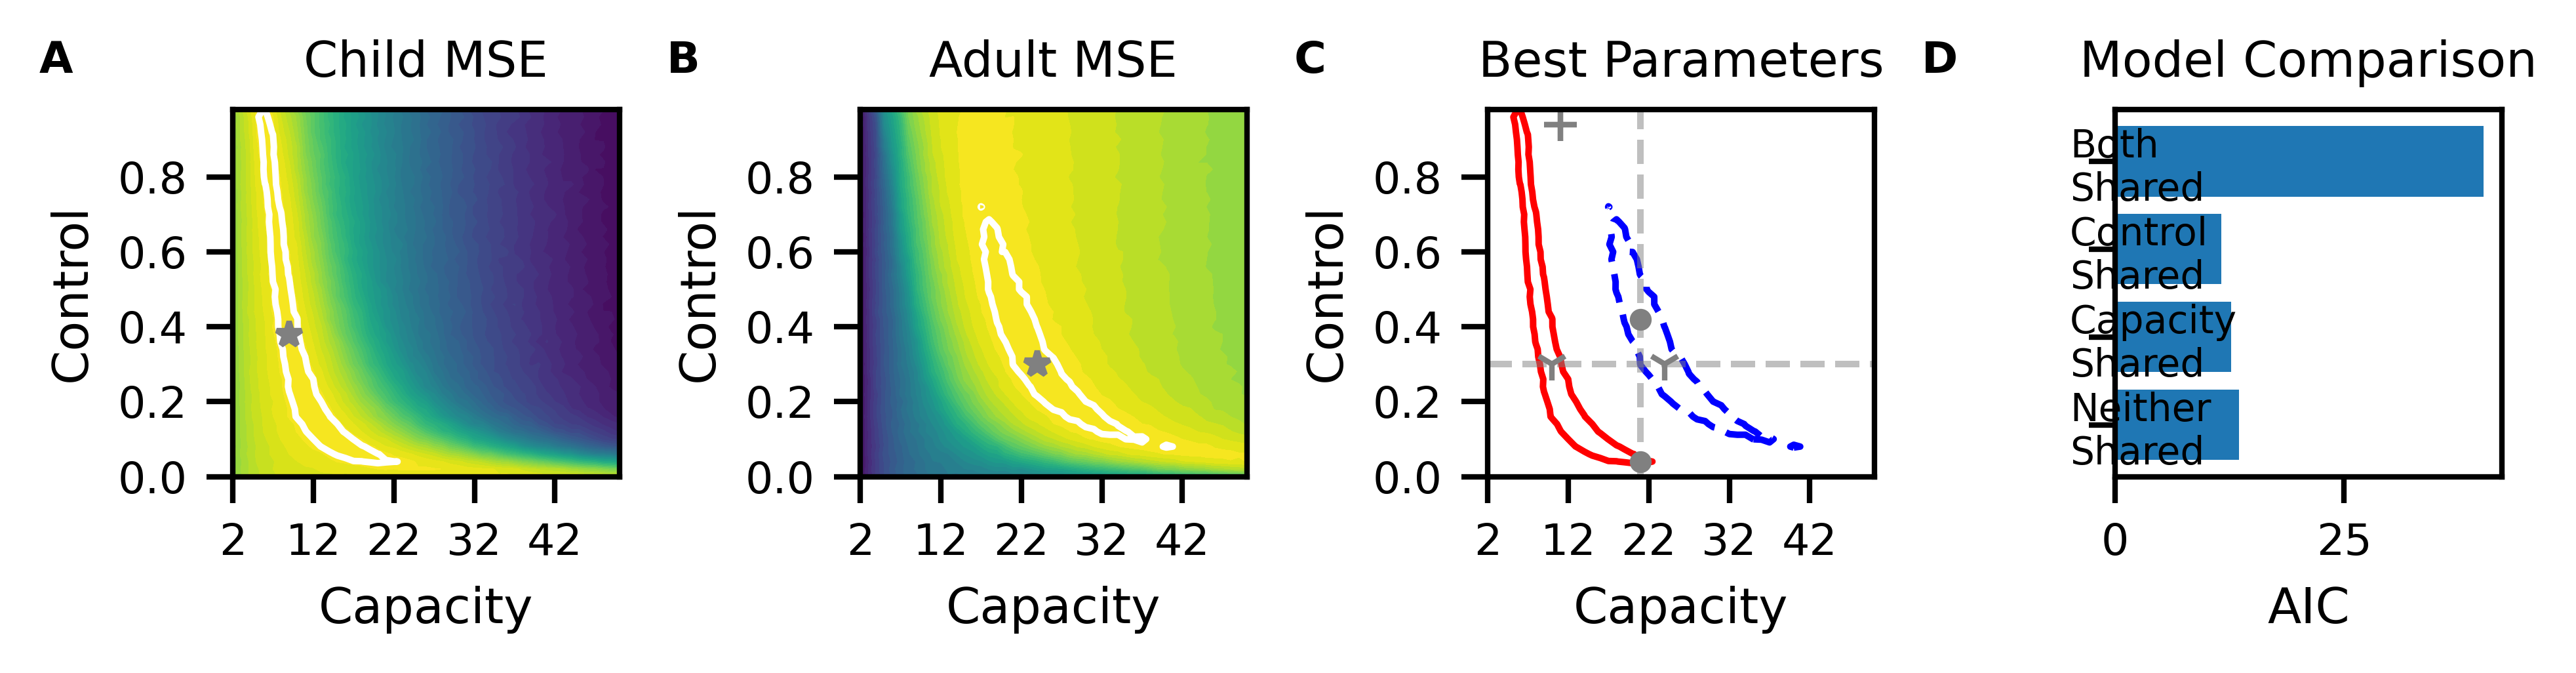

Python: None

In [18]:
include("setupPythonPlot.jl")
# now for each hyp_idx, plot the mse...
group_ls = ["-", "--"]
group_c = ["r", "b"]

this_NT = NT_vals[1]
this_ms = mem_slopes[1]
model_names = ["Both_Flex", "Share_Q", "Share_Eps", "Share_Both"]
model_names_nice = ["Neither Shared", "Capacity Shared", "Control Shared", "Both Shared"]
model_names_nice_split = ["Neither\nShared", "Capacity\nShared", "Control\nShared", "Both\nShared"]


group_names = ["Child", "Adult"]

lab_inc = 10

model_markers = ["*", ".", "1", "+"]


fig,ax = subplots(1, 4, figsize=(6.5,1.75), dpi= 600, tight_layout=false)

for group_idx = 0:1
    if group_idx == 0
        this_mse = child_mse_all
    else
        this_mse = adult_mse_all
    end


    if smooth_image
        this_mse = imfilter(this_mse, Kernel.gaussian(1))
    end
    #this_mse_s = imfilter(this_mse, Kernel.gaussian(.5))
    ax[group_idx].contourf(-1*this_mse[:, :], levels = 40)
    this_val_5 = percentile(this_mse[:,:][:], 5)
    this_val_1 = percentile(this_mse[:,:][:], 2.5)


    ax[group_idx].contour(this_mse[:,:], levels = [this_val_5],  colors = "w")


    ax[group_idx].set_yticks(0:lab_inc:N_eps-1)
    ax[group_idx].set_yticklabels(c_vals[1:lab_inc:N_eps])
    ax[group_idx].set_ylabel("Control")

    ax[group_idx].set_xticks(0:lab_inc:N_q-1)
    ax[group_idx].set_xticklabels(q_vals[1:lab_inc:N_q])
    ax[group_idx].set_xlabel("Capacity")

    # ax[group_idx].invert_yaxis()



    for (m_idx,m_name) in enumerate(model_names[1:1])
        
        q_idx = findfirst(model_info[m_name][string(group_names[group_idx+1], "_Q")] .== q_vals);
        eps_idx = findfirst(model_info[m_name][string(group_names[group_idx+1], "_Eps")] .== eps_vals);
        ax[group_idx].plot(q_idx-1, eps_idx-1, model_markers[m_idx], color = "gray", label = model_names_nice[m_idx])

    end
        
        # ax[group_idx].plot(min_idx[2]-1, min_idx[1]-1, model_markers[], color = "gray")
    
    # find the minimum index, 
    #min_idx = argmin(this_mse[:,:])

    #ax[group_idx].plot(min_idx[2]-1, min_idx[1]-1, '*', color = "gray")
    ax[group_idx].set_title(string(group_names[group_idx+1], " MSE"))
#    fig.suptitle("NT: $(this_NT), MS: $(this_ms)")


    CS = ax[2].contour(this_mse[:,:], levels = [this_val_5], colors = group_c[group_idx+1], linestyles = group_ls[group_idx + 1])
    ax[2].set_ylabel("Control")
    ax[2].set_xlabel("Capacity")
    ax[2].set_title("Best Parameters")

    CS.collections[0].set_label(group_names[group_idx+1])
    
    for (m_idx,m_name) in enumerate(model_names[2:end])
        
        q_idx = findfirst(model_info[m_name][string(group_names[group_idx+1], "_Q")] .== q_vals);
        eps_idx = findfirst(model_info[m_name][string(group_names[group_idx+1], "_Eps")] .== eps_vals);
        ax[2].plot(q_idx-1, eps_idx-1, model_markers[m_idx+1], ms = 6, color = "gray")

    end

    # ax[2].plot(min_idx[2]-1, min_idx[1]-1, '*', color = "gray")

end

ax[2].hlines(findfirst(model_info["Share_Eps"]["Child_Eps"]  .== eps_vals)-1, xmin = 0, xmax = N_q-1, ls = "--", alpha = .5, color = "gray")
ax[2].vlines(findfirst(model_info["Share_Q"]["Child_Q"]  .== q_vals)-1, ymin = 0, ymax = N_eps-1, alpha = .5, ls = "--", color = "gray")

ax[2].set_yticks(0:lab_inc:(N_eps-1))
ax[2].set_yticklabels(c_vals[1:lab_inc:end])
# ax[2].invert_yaxis()

ax[2].set_xticks(0:lab_inc:(N_q-1))
ax[2].set_xticklabels(q_vals[1:lab_inc:end])

#ax[0].legend(loc = (-2,0), fontsize = 6)

# plot model comparison in 4th panel...
mses = [model_info[m]["Both_MSE"] for m in model_names]
nps = [6,5,5,3]

aics = 2*nps - -1*mses
ax[3].barh(1:4, aics)
ax[3].set_yticks(1:4)
ax[3].set_yticklabels(model_names_nice_split, rotation = 0, fontsize = 7, ha = "left")
#ax[3].x_ticklabels.set_ha("left")

ax[3].set_xlabel("AIC")
ax[3].set_title("Model Comparison")
# ax[3].set_xscale("log")


these_labels = ["A", "B", "C", "D"]
for (l_idx, l) in enumerate(these_labels)
    ax[l_idx-1].text(-.5, 1.1, l, transform = ax[l_idx-1].transAxes, weight = "bold")
end

savefig("Cog_Sci_Plots/Model_Comp.svg", format = "svg")
savefig("Cog_Sci_Plots/Model_Comp.png", format = "png")

savefig("Cog_Sci_Plots/Model_Comp.svg", format = "svg")
savefig("Cog_Sci_Plots/Model_Comp.png", format = "png")

In [16]:
model_info["Both_Flex"]

Dict{Any, Any} with 7 entries:
  "Child_Eps" => 0.62
  "Child_Q"   => 9
  "Child_MSE" => 0.526693
  "Adult_MSE" => 1.02517
  "Adult_Q"   => 24
  "Adult_Eps" => 0.7
  "Both_MSE"  => 1.55186

In [20]:
aics .- minimum(aics)

4-element Vector{Float64}:
  1.933361931498899
  1.0737743504700887
  0.0
 28.56089572535381

#### Plot Experiment 1 Recovery

In [28]:
"""
function exp1_plot_cowan_k_bars(this_cowan_k, ax; group_name = "7 year olds")
    x_vals = Vector(1:4) .- .2
    y_vals = [this_cowan_k[[1 3]] this_cowan_k[[5 7]]]
    ax.bar(x_vals, y_vals, .4, label = "Cued")

    x_vals = Vector(1:4) .+ .2
    y_vals = [this_cowan_k[[2 4]] this_cowan_k[[6 8]]]
    ax.bar(x_vals, y_vals, .4, label = "Neutral")
    ax.set_ylim(0,4)

    ax.set_xticks(1:4)
    ax.set_xticklabels(["Load2Pre", "Load2Retro", "Load4Pre", "Load4Retro"], rotation = 90)
    ax.set_title(group_name)
    ax.set_ylabel("Cowan's K")
end
"""

# model_markers = ["1", ".", "*", "+"]
#model_colors = [""]

model_offsets = 5 .* [-.03, -.01, .01, .03]

function exp1_plot_cowan_k_bars_compare(this_cowan_k_data,this_cowan_k_model, ax; ms = 4, model_name = "", model_offset = 0, model_marker = "o", plot_data = true, include_ylabel = true, group_name = "Children")
    
    
    if plot_data
    
        this_cowan_k = this_cowan_k_data
        x_vals = Vector(1:4) .- .2
        y_vals = [this_cowan_k[[1 3]] this_cowan_k[[5 7]]]
        ax.bar(x_vals, y_vals, .4, label = "Cued", alpha = .5)

        x_vals = Vector(1:4.1) .+ .2
        y_vals = [this_cowan_k[[2 4]] this_cowan_k[[6 8]]]
        ax.bar(x_vals, y_vals, .4, label = "Neutral", alpha=.5)
        ax.set_ylim(0,4.1)
        
        ax.hlines([2], xmin = .6, xmax = 2.4, color = "black", ls = "--", alpha = .25)
        ax.hlines([4], xmin = 2.6, xmax = 4.4, color = "black", ls = "--", alpha = .25, label = "Perfect Memory")

        
    end
    
    
    this_cowan_k = this_cowan_k_model
    x_vals = Vector(1:4) .- .2 .+ model_offset
    y_vals = [this_cowan_k[[1 3]] this_cowan_k[[5 7]]]'
    # print(y_vals)
    ax.plot(x_vals, y_vals, model_marker, color = "gray", ms = ms)

    x_vals = Vector(1:4) .+ .2 .+ model_offset
    y_vals = [this_cowan_k[[2 4]] this_cowan_k[[6 8]]]'
    ax.plot(x_vals, y_vals, model_marker, color = "gray", ms = ms, label = model_name)
    ax.set_ylim(0,4.1)
    
    ax.set_xticks(1:4)
    ax.set_xticklabels(["Load2Pre", "Load2Retro", "Load4Pre", "Load4Retro"], rotation = 30)
    ax.set_title(group_name)
    
    if include_ylabel
        ax.set_ylabel("Cowan's K")
    end
end

#fig,ax = subplots(1, 2,  figsize = (4.75,3), dpi=200,constrained_layout=true, sharey=false)
"""
fig,ax = subplots(1, 2,  figsize = (4,2), dpi=200,constrained_layout=true, sharey=false)

for (model_idx, model_name) in enumerate(model_names)

    this_model = model_info[model_name]

    ms = mem_slopes[1]
    nt = NT_vals[1]

    # fig,ax = subplots(1, 2,  figsize = (3,2.5), dpi=200,constrained_layout=true, sharey=false)
    
    if model_idx == 1
        plot_data = true
    else
        plot_data = false
    end

    exp1_cowan_k_model_adult = load_cowan_k(this_model["Adult_Eps"], Int(this_model["Adult_Q"]), nt,ms; exp_num = 1, on_cluster = false)
    exp1_cowan_k_model_7_yr = load_cowan_k(this_model["Child_Eps"], Int(this_model["Child_Q"]), nt,ms; exp_num = 1, on_cluster = false)

    #exp1_plot_cowan_k_bars(exp1_cowan_k_model_7_yr, ax[0])
    #exp1_plot_cowan_k_bars(exp1_cowan_k_model_adult, ax[1], group_name = "Adults")

    exp1_plot_cowan_k_bars_compare(exp1_cowan_k_true_7_yr, exp1_cowan_k_model_7_yr, ax[0], plot_data = plot_data, model_name = model_names_nice[model_idx], model_offset = model_offsets[model_idx], model_marker = model_markers[model_idx], include_ylabel = true)
    exp1_plot_cowan_k_bars_compare(exp1_cowan_k_true_adult, exp1_cowan_k_model_adult, ax[1], plot_data = plot_data, model_name = model_names_nice[model_idx], model_offset = model_offsets[model_idx],model_marker = model_markers[model_idx], include_ylabel = false, group_name = "Adults")

    #ax[0].legend(loc = "upper left")
    #fig.suptitle(model_names_nice[model_idx]);
end

ax[1].legend(loc = (1.1, 0))
"""

"fig,ax = subplots(1, 2,  figsize = (4,2), dpi=200,constrained_layout=true, sharey=false)\n\nfor (model_idx, model_name) in enumerate(model_names)\n\n    this_model = model_info[model_name]\n\n    ms = mem_slopes[1]\n    nt = NT_vals[1]\n\n    # fig,ax = subplots(1, 2,  figsize = " ⋯ 969 bytes ⋯ "mes_nice[model_idx], model_offset = model_offsets[model_idx],model_marker = model_markers[model_idx], include_ylabel = false, group_name = \"Adults\")\n\n    #ax[0].legend(loc = \"upper left\")\n    #fig.suptitle(model_names_nice[model_idx]);\nend\n\nax[1].legend(loc = (1.1, 0))\n"

#### Plot Experiment 2 Recovery

In [29]:

function exp2_plot_cowan_k_bars_compare(this_cowan_k_data, this_cowan_k_model, ax; include_ylabel = true, ms = 4, model_name = "", model_offset = 0, model_marker = "o", plot_data = true, use_ylabel = true, group_name = "Children")
    
    
    if plot_data
        this_cowan_k = this_cowan_k_data

        x_vals = Vector(1:2) .- .2
        y_vals = this_cowan_k[[1 3]]
        ax.bar(x_vals, y_vals, .4, alpha = .5, label = "Cued")

        x_vals = Vector(1:2) .+ .2
        y_vals = this_cowan_k[[2 4]]
        ax.bar(x_vals, y_vals, .4, alpha = .5, label = "Neutral")
        ax.set_ylim(0,4)
        
        
        ax.hlines([4], xmin = .6, xmax = 2.4, color = "black", ls = "--", alpha = .25)
        #ax.hlines([4], xmin = 2.6, xmax = 4.4, color = "black", ls = "--", alpha = .25)
        
    end
    
    this_cowan_k = this_cowan_k_model
    
    x_vals = Vector(1:2) .- .2 .+ model_offset
    y_vals = this_cowan_k[[1 3]]'
    ax.plot(x_vals, y_vals, model_marker, color = "gray", label = model_name, ms = ms)

    x_vals = Vector(1:2) .+ .2 .+ model_offset
    y_vals = this_cowan_k[[2 4]]'
    ax.plot(x_vals, y_vals, model_marker, color = "gray", ms = ms)
    ax.set_ylim(0,4.1)


    #ax.legend()

    ax.set_xticks(1:2)
    ax.set_xticklabels(["IM", "VSTM"], rotation = 30)

    ax.set_title(group_name)
    
    if include_ylabel
        ax.set_ylabel("Cowan's K")
    end
    
end
"""
fig,ax = subplots(1, 2, figsize = (2, 2), dpi=200,constrained_layout=true, sharey=true)

for (model_idx, model_name) in enumerate(model_names)

    this_model = model_info[model_name]

    # neutral performance isn't falling over time at low number of quanta... 
    # maybe this reflects 

    ms = mem_slopes[1]
    nt = NT_vals[1]
    
    


    exp2_cowan_k_model_adult = load_cowan_k(this_model["Adult_Eps"], Int(this_model["Adult_Q"]), nt,ms; exp_num = 2, on_cluster = false)
    exp2_cowan_k_model_7_yr = load_cowan_k(this_model["Child_Eps"], Int(this_model["Child_Q"]), nt,ms; exp_num = 2, on_cluster = false)
    
    if model_idx == 1
        plot_data = true
    else
        plot_data = false
    end


    exp2_plot_cowan_k_bars_compare(exp2_cowan_k_true_7_yr,exp2_cowan_k_model_7_yr,ax[0], include_ylabel = true, model_offset = model_offsets[model_idx], model_name = model_names_nice[model_idx], model_marker = model_markers[model_idx], plot_data = plot_data)
    exp2_plot_cowan_k_bars_compare(exp2_cowan_k_model_adult,exp2_cowan_k_true_adult,ax[1],include_ylabel = false, model_offset = model_offsets[model_idx], model_name = model_names_nice[model_idx], model_marker = model_markers[model_idx],plot_data = plot_data, group_name = "Adults")
    #ax[0].legend(fontsize = 6)
end
ax[1].legend(loc = (1.1, 0))
"""

"fig,ax = subplots(1, 2, figsize = (2, 2), dpi=200,constrained_layout=true, sharey=true)\n\nfor (model_idx, model_name) in enumerate(model_names)\n\n    this_model = model_info[model_name]\n\n    # neutral performance isn't falling over time at low number of quanta... \n    # ma" ⋯ 782 bytes ⋯ "adult,ax[1],include_ylabel = false, model_offset = model_offsets[model_idx], model_name = model_names_nice[model_idx], model_marker = model_markers[model_idx],plot_data = plot_data, group_name = \"Adults\")\n    #ax[0].legend(fontsize = 6)\nend\nax[1].legend(loc = (1.1, 0))\n"

### Experiment 3 recovery

In [30]:
function exp3a_plot_cowan_k_bars_compare(this_cowan_k_data, this_cowan_k_model, ax; include_ylabel = true, ms = 4, model_name = "", model_offset = 0, model_marker = "o", plot_data = true, use_ylabel = true, group_name = "Children")

    # plot data
    text_height = 5
    
    if group_name == "Children" # add the load 6 ims...

        if plot_data
                
            this_cowan_k = this_cowan_k_data
            # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral

            cowan_k_load_6_IM_cued = this_cowan_k[1,3]
            cowan_k_load_6_IM_neutral = this_cowan_k[1,4]


            cued_cowan_k_load_3 =  [this_cowan_k[:,1]; cowan_k_load_6_IM_cued]
            neutral_cowan_k_load_3 =  [this_cowan_k[:,2]; cowan_k_load_6_IM_neutral]

            x_vals = [1:3; 5.25] .- .2
            y_vals = cued_cowan_k_load_3
            ax.bar(x_vals, y_vals, .4, alpha = .5, label = "Cued")

            x_vals = [1:3; 5.25] .+ .2
            y_vals = neutral_cowan_k_load_3
            ax.bar(x_vals, y_vals, .4, alpha = .5, label = "Neutral")
            
            ax.set_xticks([1:3; 5.25])
            ax.set_xticklabels(["IM", "VSTM", "long VSTM", "IM"], rotation = 30)
            ax.vlines(4.125, ymin = 0, ymax = 6.15, ls = "--", colors = "gray")
            
            ax.text(2, text_height, "Load 3", horizontalalignment = "center", color = "gray")
            ax.text(5.30, text_height, "Load 6", horizontalalignment = "center", color = "gray")
            
            ax.hlines([3], xmin = .6, xmax = 3.4, color = "black", ls = "--", alpha = .25)
            
            xmin = 5.25 - .4
            xmax = 5.25 + .4
            ax.hlines([6], xmin = xmin, xmax = xmax, color = "black", ls = "--", alpha = .25)

        end
        
        
        # plot model
        this_cowan_k = this_cowan_k_model
        
        cowan_k_load_6_IM_cued = this_cowan_k[1,3]
        cowan_k_load_6_IM_neutral = this_cowan_k[1,4]

        cued_cowan_k_load_3 = [this_cowan_k[:,1]; cowan_k_load_6_IM_cued]
        neutral_cowan_k_load_3 = [this_cowan_k[:,2]; cowan_k_load_6_IM_neutral]

        x_vals = [1:3; 5.25] .- .2 .+ model_offset
        y_vals = cued_cowan_k_load_3
        ax.plot(x_vals, y_vals, model_marker, color = "gray", ms = ms, label = model_name)

        x_vals = [1:3; 5.25] .+ .2 .+ model_offset
        y_vals = neutral_cowan_k_load_3 
        ax.plot(x_vals, y_vals,  model_marker, color = "gray", ms = ms)
        
        ax.set_xlim(0,6.5)
                
    else
        if plot_data
                
            this_cowan_k = this_cowan_k_data
            # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral

            # so first do Load 3 - cued, varying length
            cowan_k_3_cued = this_cowan_k[:,1]
            x_vals = Vector(1:3) .- .2
            y_vals = cowan_k_3_cued
            ax.bar(x_vals, y_vals, .4, alpha = .5, label = "Cued")

            cowan_k_3_neutral = this_cowan_k[:,2]
            x_vals = Vector(1:3) .+ .2
            y_vals = cowan_k_3_neutral
            ax.bar(x_vals, y_vals, .4, alpha = .5,label = "Neutral")

            cowan_k_6_cued = this_cowan_k[:,3]
            x_vals = collect(5.25:1:7.25) .- .2
            y_vals = cowan_k_6_cued
            ax.bar(x_vals, y_vals, .4, alpha = .5,label = "Cued", color = "C0")

            cowan_k_6_neutral = this_cowan_k[:,4]
            x_vals = collect(5.25:1:7.25) .+ .2
            y_vals = cowan_k_6_neutral
            ax.bar(x_vals, y_vals, .4, alpha = .5,label = "Neutral", color = "C1")
            
            ax.vlines(4.125, ymin = 0, ymax = 6.15, ls = "--", colors = "gray")
            
            ax.text(2, text_height, "Load 3", horizontalalignment = "center", color = "gray")
            ax.text(6.25, text_height, "Load 6", horizontalalignment = "center", color = "gray")
            
            ax.set_xticks([1:3; collect(5.25:1:7.25)])
            ax.set_xticklabels(["IM", "VSTM", "long VSTM", "IM", "VSTM", "long VSTM"], rotation = 30)
            
            ax.hlines([3], xmin = .6, xmax = 3.4, color = "black", ls = "--", alpha = .25)
            
            xmin = 5.25 - .4
            xmax = 7.25 + .4
            ax.hlines([6], xmin = xmin, xmax = xmax, color = "black", ls = "--", alpha = .25)

        end
        
        # plot model
        this_cowan_k = this_cowan_k_data
        
        # Load 3 cued, Load 3 Neutral, Load 6 cued, Load 6 neutral

        # so first do Load 3 - cued, varying length
        cowan_k_3_cued = this_cowan_k[:,1]
        x_vals = Vector(1:3) .- .2 .+ model_offset
        y_vals = cowan_k_3_cued
        ax.plot(x_vals, y_vals,  model_marker, color = "gray", ms = ms)

        cowan_k_3_neutral = this_cowan_k[:,2]
        x_vals = Vector(1:3) .+ .2 .+ model_offset
        y_vals = cowan_k_3_neutral
        ax.plot(x_vals, y_vals, model_marker, color = "gray", ms = ms)

        cowan_k_6_cued = this_cowan_k[:,3]
        x_vals = collect(5.25:1:7.25) .- .2 .+ model_offset
        y_vals = cowan_k_6_cued
        ax.plot(x_vals, y_vals,  model_marker, color = "gray", ms = ms)

        cowan_k_6_neutral = this_cowan_k[:,4]
        x_vals = collect(5.25:1:7.25) .+ .2 .+ model_offset
        y_vals = cowan_k_6_neutral
        ax.plot(x_vals, y_vals, model_marker, color = "gray", ms = ms)

        
    end

    


    ax.set_title(group_name)
    if include_ylabel
        ax.set_ylabel("Cowan's K")
    end
    ax.set_ylim(0,6.15)

end


exp3a_plot_cowan_k_bars_compare (generic function with 1 method)

#### Make the big plot

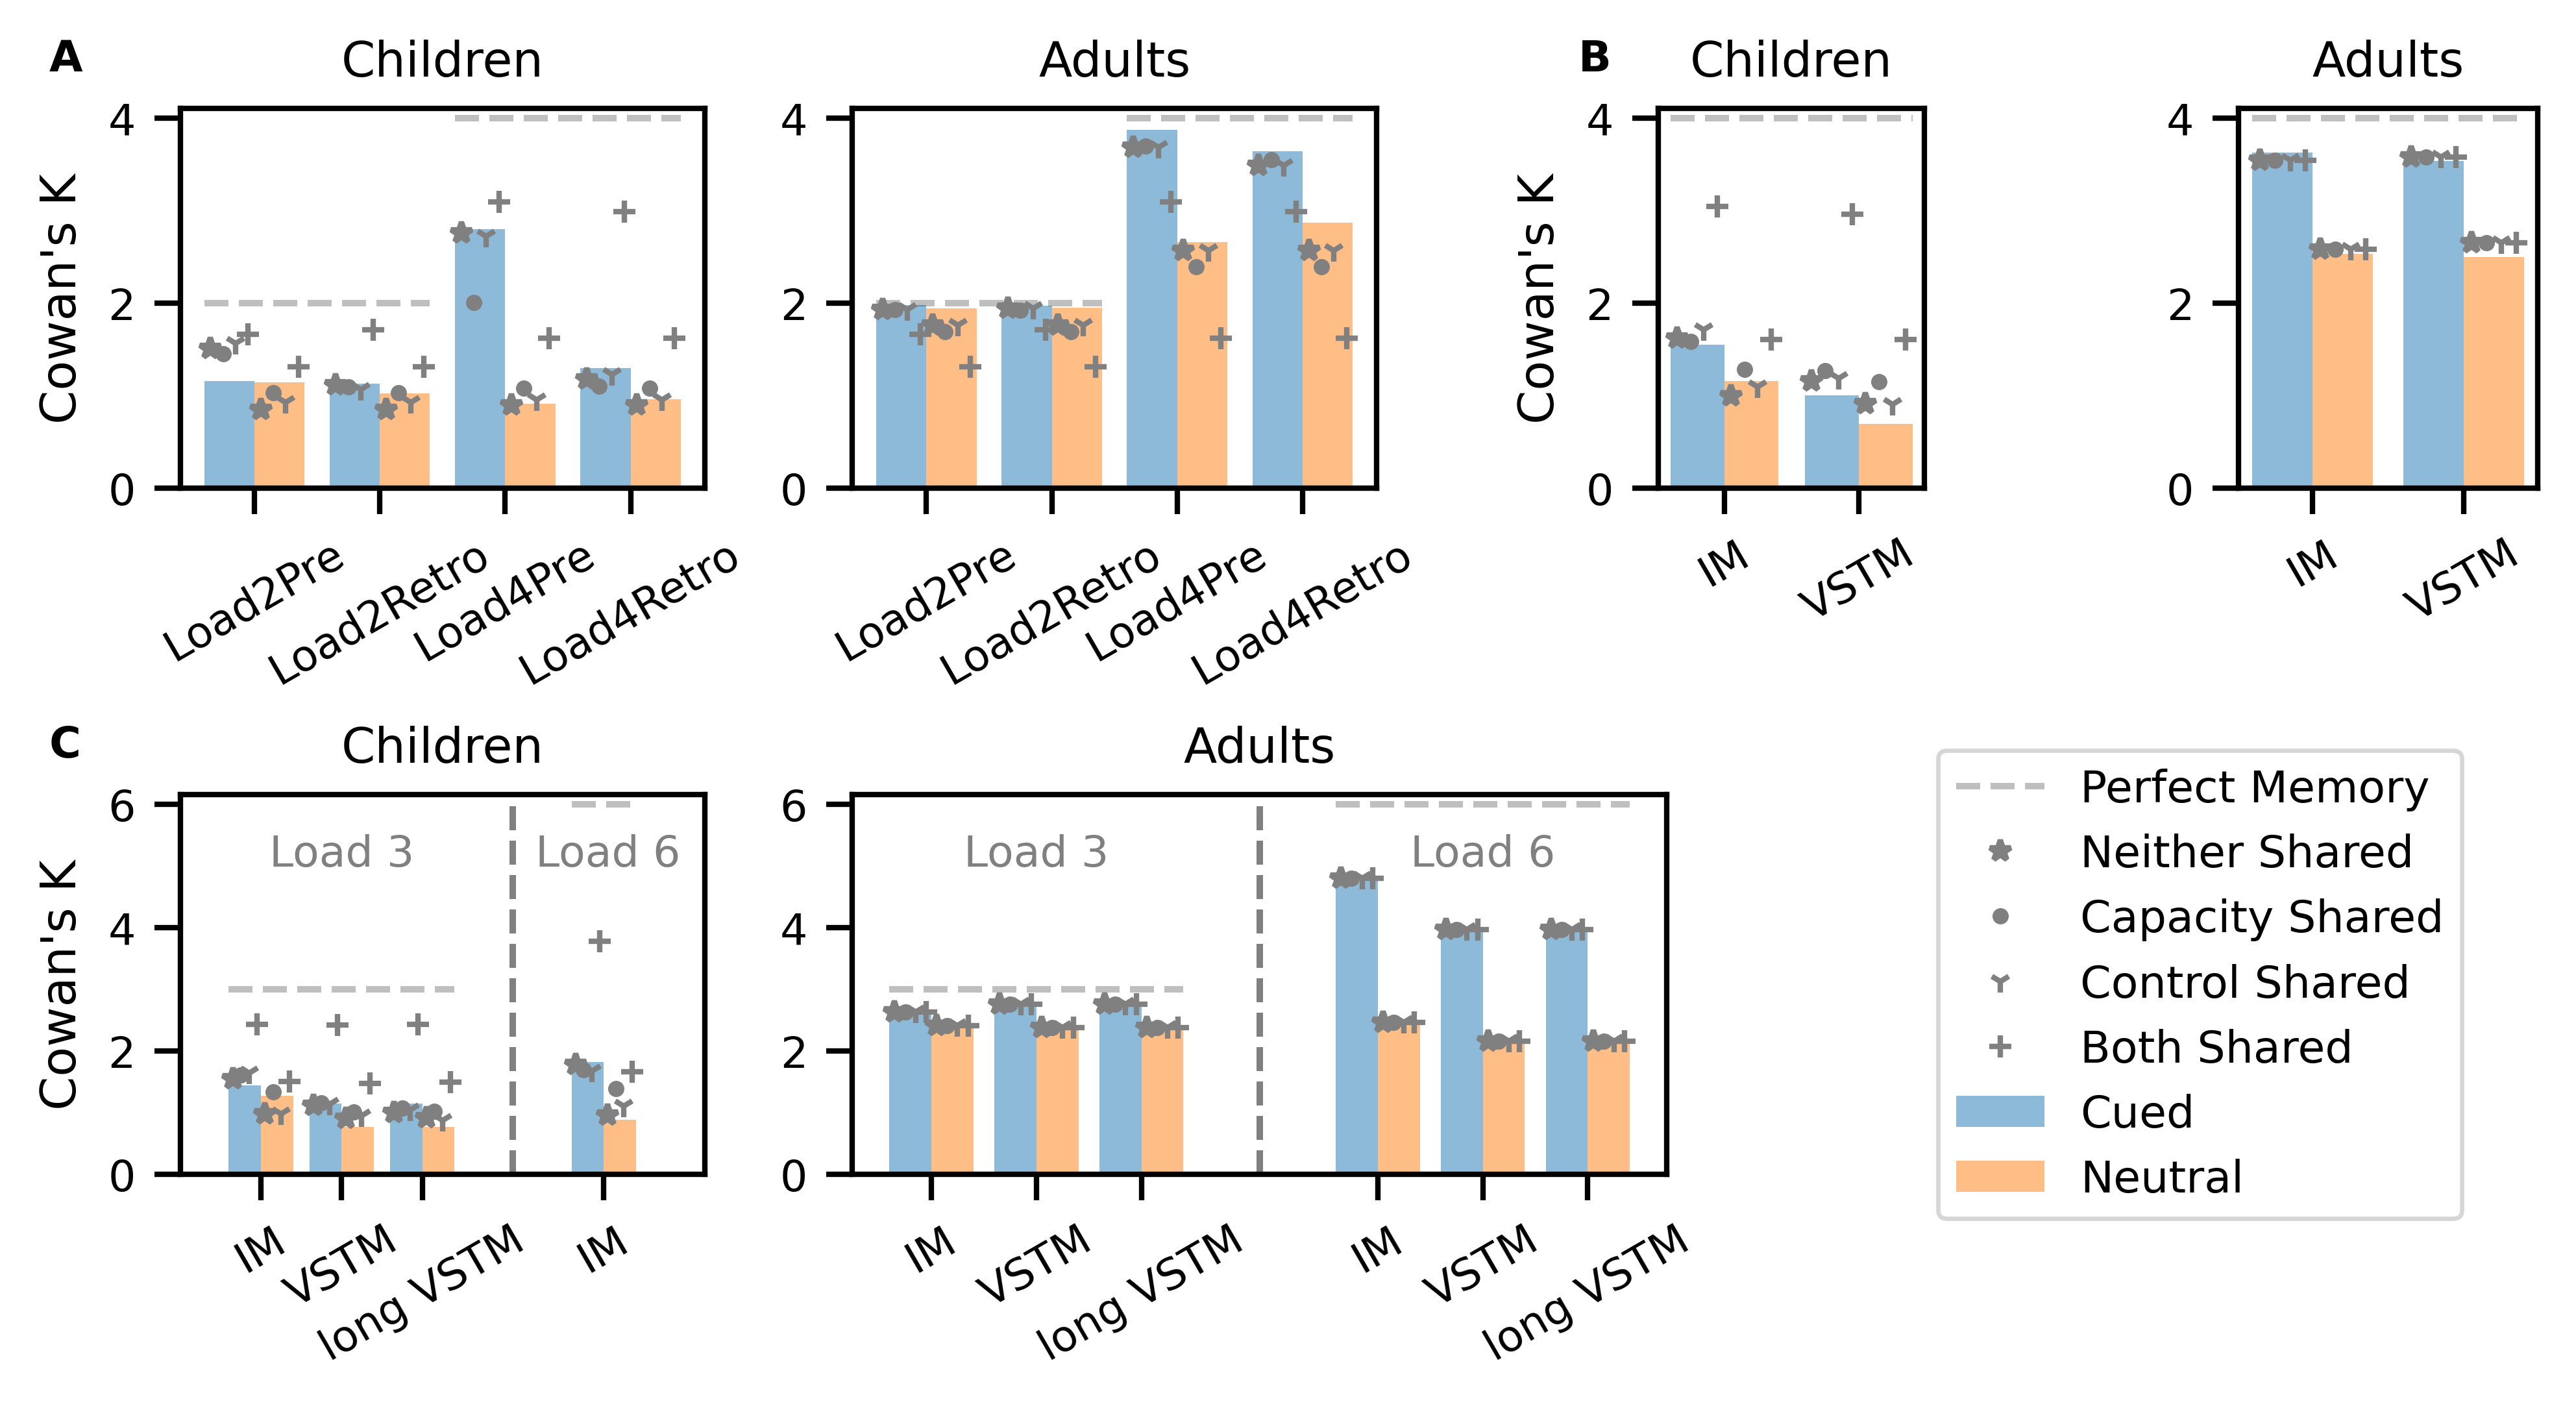

Python: None

In [64]:
#fig,ax = subplots(2, 4,  figsize = (6,4), dpi=200,constrained_layout=true, sharey=false, gridspec_kw = Dict("width_ratios"=> [4,4,2,2]))

fig, ax = matplotlib.pyplot.subplot_mosaic([["A1", "A1", "A1", "A2", "A2", "A2", "B1","B1", "B2", "B2"], ["C1", "C1", "C1", "C2", "C2", "C2", "C2", "D", "D", "D"]], figsize = (6.5,3.5), dpi=600,constrained_layout=true)

### Experiment 1
for (model_idx, model_name) in enumerate(model_names)

    this_model = model_info[model_name]

    ms = mem_slopes[1]
    nt = NT_vals[1]

    # fig,ax = subplots(1, 2,  figsize = (3,2.5), dpi=200,constrained_layout=true, sharey=false)
    
    if model_idx == 1
        plot_data = true
    else
        plot_data = false
    end

    exp1_cowan_k_model_adult = load_cowan_k(this_model["Adult_Eps"], Int(this_model["Adult_Q"]), nt,ms; exp_num = 1, on_cluster = false)
    exp1_cowan_k_model_7_yr = load_cowan_k(this_model["Child_Eps"], Int(this_model["Child_Q"]), nt,ms; exp_num = 1, on_cluster = false)

    #exp1_plot_cowan_k_bars(exp1_cowan_k_model_7_yr, ax[0])
    #exp1_plot_cowan_k_bars(exp1_cowan_k_model_adult, ax[1], group_name = "Adults")

    exp1_plot_cowan_k_bars_compare(exp1_cowan_k_true_7_yr, exp1_cowan_k_model_7_yr, ax["A1"], plot_data = plot_data, model_name = model_names_nice[model_idx], model_offset = model_offsets[model_idx], model_marker = model_markers[model_idx], include_ylabel = true)
    # exp1_plot_cowan_k_bars_compare(exp1_cowan_k_true_7_yr, exp1_cowan_k_model_7_yr, ax[1,2], plot_data = plot_data, model_name = model_names_nice[model_idx], model_offset = model_offsets[model_idx], model_marker = model_markers[model_idx], include_ylabel = true)

    exp1_plot_cowan_k_bars_compare(exp1_cowan_k_true_adult, exp1_cowan_k_model_adult, ax["A2"], plot_data = plot_data, model_name = model_names_nice[model_idx], model_offset = model_offsets[model_idx],model_marker = model_markers[model_idx], include_ylabel = false, group_name = "Adults")

    #ax[0].legend(loc = "upper left")
    #fig.suptitle(model_names_nice[model_idx]);
end

#fig,ax = subplots(1, 2,  figsize = (4,2), dpi=200,constrained_layout=true, sharey=false)

# experiment 2

for (model_idx, model_name) in enumerate(model_names)

    this_model = model_info[model_name]

    # neutral performance isn't falling over time at low number of quanta... 
    # maybe this reflects 

    ms = mem_slopes[1]
    nt = NT_vals[1]
    
    exp2_cowan_k_model_adult = load_cowan_k(this_model["Adult_Eps"], Int(this_model["Adult_Q"]), nt,ms; exp_num = 2, on_cluster = false)
    exp2_cowan_k_model_7_yr = load_cowan_k(this_model["Child_Eps"], Int(this_model["Child_Q"]), nt,ms; exp_num = 2, on_cluster = false)
    
    if model_idx == 1
        plot_data = true
    else
        plot_data = false
    end


    exp2_plot_cowan_k_bars_compare(exp2_cowan_k_true_7_yr,exp2_cowan_k_model_7_yr, ax["B1"], include_ylabel = true, model_offset = model_offsets[model_idx], model_name = model_names_nice[model_idx], model_marker = model_markers[model_idx], plot_data = plot_data)
    exp2_plot_cowan_k_bars_compare(exp2_cowan_k_model_adult,exp2_cowan_k_true_adult,ax["B2"], include_ylabel = false, model_offset = model_offsets[model_idx], model_name = model_names_nice[model_idx], model_marker = model_markers[model_idx],plot_data = plot_data, group_name = "Adults")
    #ax[0].legend(fontsize = 6)
end

# ax[3].legend(loc = (1.1, 0))

# experiment 3

ms = mem_slopes[1]
nt = NT_vals[1]

for (model_idx, model_name) in enumerate(model_names)

    this_model = model_info[model_name]

    exp3a_cowan_k_model_adult = load_cowan_k(this_model["Adult_Eps"], Int(this_model["Adult_Q"]), nt,ms;exp_num = 3, on_cluster = false)
    exp3a_cowan_k_model_7_yr = load_cowan_k(this_model["Child_Eps"], Int(this_model["Child_Q"]), nt,ms;  exp_num = 3, on_cluster = false)
    
    if model_idx == 1
        plot_data = true
    else
        plot_data = false
    end

    exp3a_plot_cowan_k_bars_compare(exp3_cowan_k_true_7_yr, exp3a_cowan_k_model_7_yr,  ax["C1"], include_ylabel = true, model_offset = model_offsets[model_idx], model_name = model_names_nice[model_idx], model_marker = model_markers[model_idx], plot_data = plot_data, group_name = "Children")
    exp3a_plot_cowan_k_bars_compare(exp3_cowan_k_true_adult, exp3a_cowan_k_model_adult, ax["C2"], include_ylabel = false, model_offset = model_offsets[model_idx], model_name = model_names_nice[model_idx], model_marker = model_markers[model_idx], plot_data = plot_data, group_name = "Adults")
end

ax["D"].set_axis_off()
#ax[1,3].set_axis_off()

handles, labels = ax["A1"].get_legend_handles_labels()

ax["D"].legend(handles, labels, loc = "center left")

# ax[1,2].clear()

ax["A1"].text(-.25, 1.1, "A", transform = ax["A1"].transAxes, weight = "bold")
ax["B1"].text(-.3, 1.1, "B", transform = ax["B1"].transAxes, weight = "bold")
ax["C1"].text(-.25, 1.1, "C", transform = ax["C1"].transAxes, weight = "bold")

savefig("Cog_Sci_Plots/Model_Recov.svg", format = "svg")
savefig("Cog_Sci_Plots/Model_Recov.png", format = "png")


### Some plots to explain how the model works
(don't change these)

### Random Actions

In [43]:
N_TimeSteps = 50
N_Quanta = 10
N_Objects = 3
epsilon = 1
state_history_random = simulate_delayed_memory_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps, 0)

50×3 Matrix{Float64}:
 2.0   7.0  1.0
 2.0   7.0  1.0
 2.0   7.0  1.0
 2.0   7.0  1.0
 3.0   6.0  1.0
 3.0   6.0  1.0
 2.0   7.0  1.0
 1.0   8.0  1.0
 1.0   8.0  1.0
 1.0   7.0  2.0
 1.0   7.0  2.0
 1.0   7.0  2.0
 0.0   8.0  2.0
 ⋮          
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0
 0.0  10.0  0.0

Directed Actions - Equal Prob Probes

In [52]:
N_TimeSteps = 100
N_Quanta = 10
N_Objects = 3
epsilon = 0
state_history_op_equal = simulate_delayed_memory_episode(N_Quanta, N_Objects, epsilon, N_TimeSteps, 0)

100×3 Matrix{Float64}:
 1.0  2.0  7.0
 2.0  2.0  6.0
 1.0  3.0  6.0
 2.0  2.0  6.0
 3.0  1.0  6.0
 3.0  2.0  5.0
 3.0  3.0  4.0
 3.0  3.0  4.0
 3.0  4.0  3.0
 2.0  4.0  4.0
 3.0  4.0  3.0
 3.0  3.0  4.0
 4.0  3.0  3.0
 ⋮         
 4.0  4.0  2.0
 4.0  3.0  3.0
 3.0  4.0  3.0
 3.0  3.0  4.0
 3.0  3.0  4.0
 4.0  3.0  3.0
 4.0  3.0  3.0
 4.0  3.0  3.0
 4.0  3.0  3.0
 4.0  2.0  4.0
 4.0  3.0  3.0
 4.0  3.0  3.0

In [45]:
N_TimeSteps = 50
N_Quanta = 10
N_Objects = 3
epsilon = 0
state_history_op_unequal = simulate_precue_episode(N_Quanta, N_Objects, epsilon, 0, N_TimeSteps)

50×3 Matrix{Float64}:
  6.0  3.0  1.0
  7.0  2.0  1.0
  8.0  1.0  1.0
  8.0  1.0  1.0
  8.0  1.0  1.0
  8.0  1.0  1.0
  8.0  1.0  1.0
  9.0  1.0  0.0
  9.0  1.0  0.0
  9.0  1.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
  ⋮         
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0
 10.0  0.0  0.0

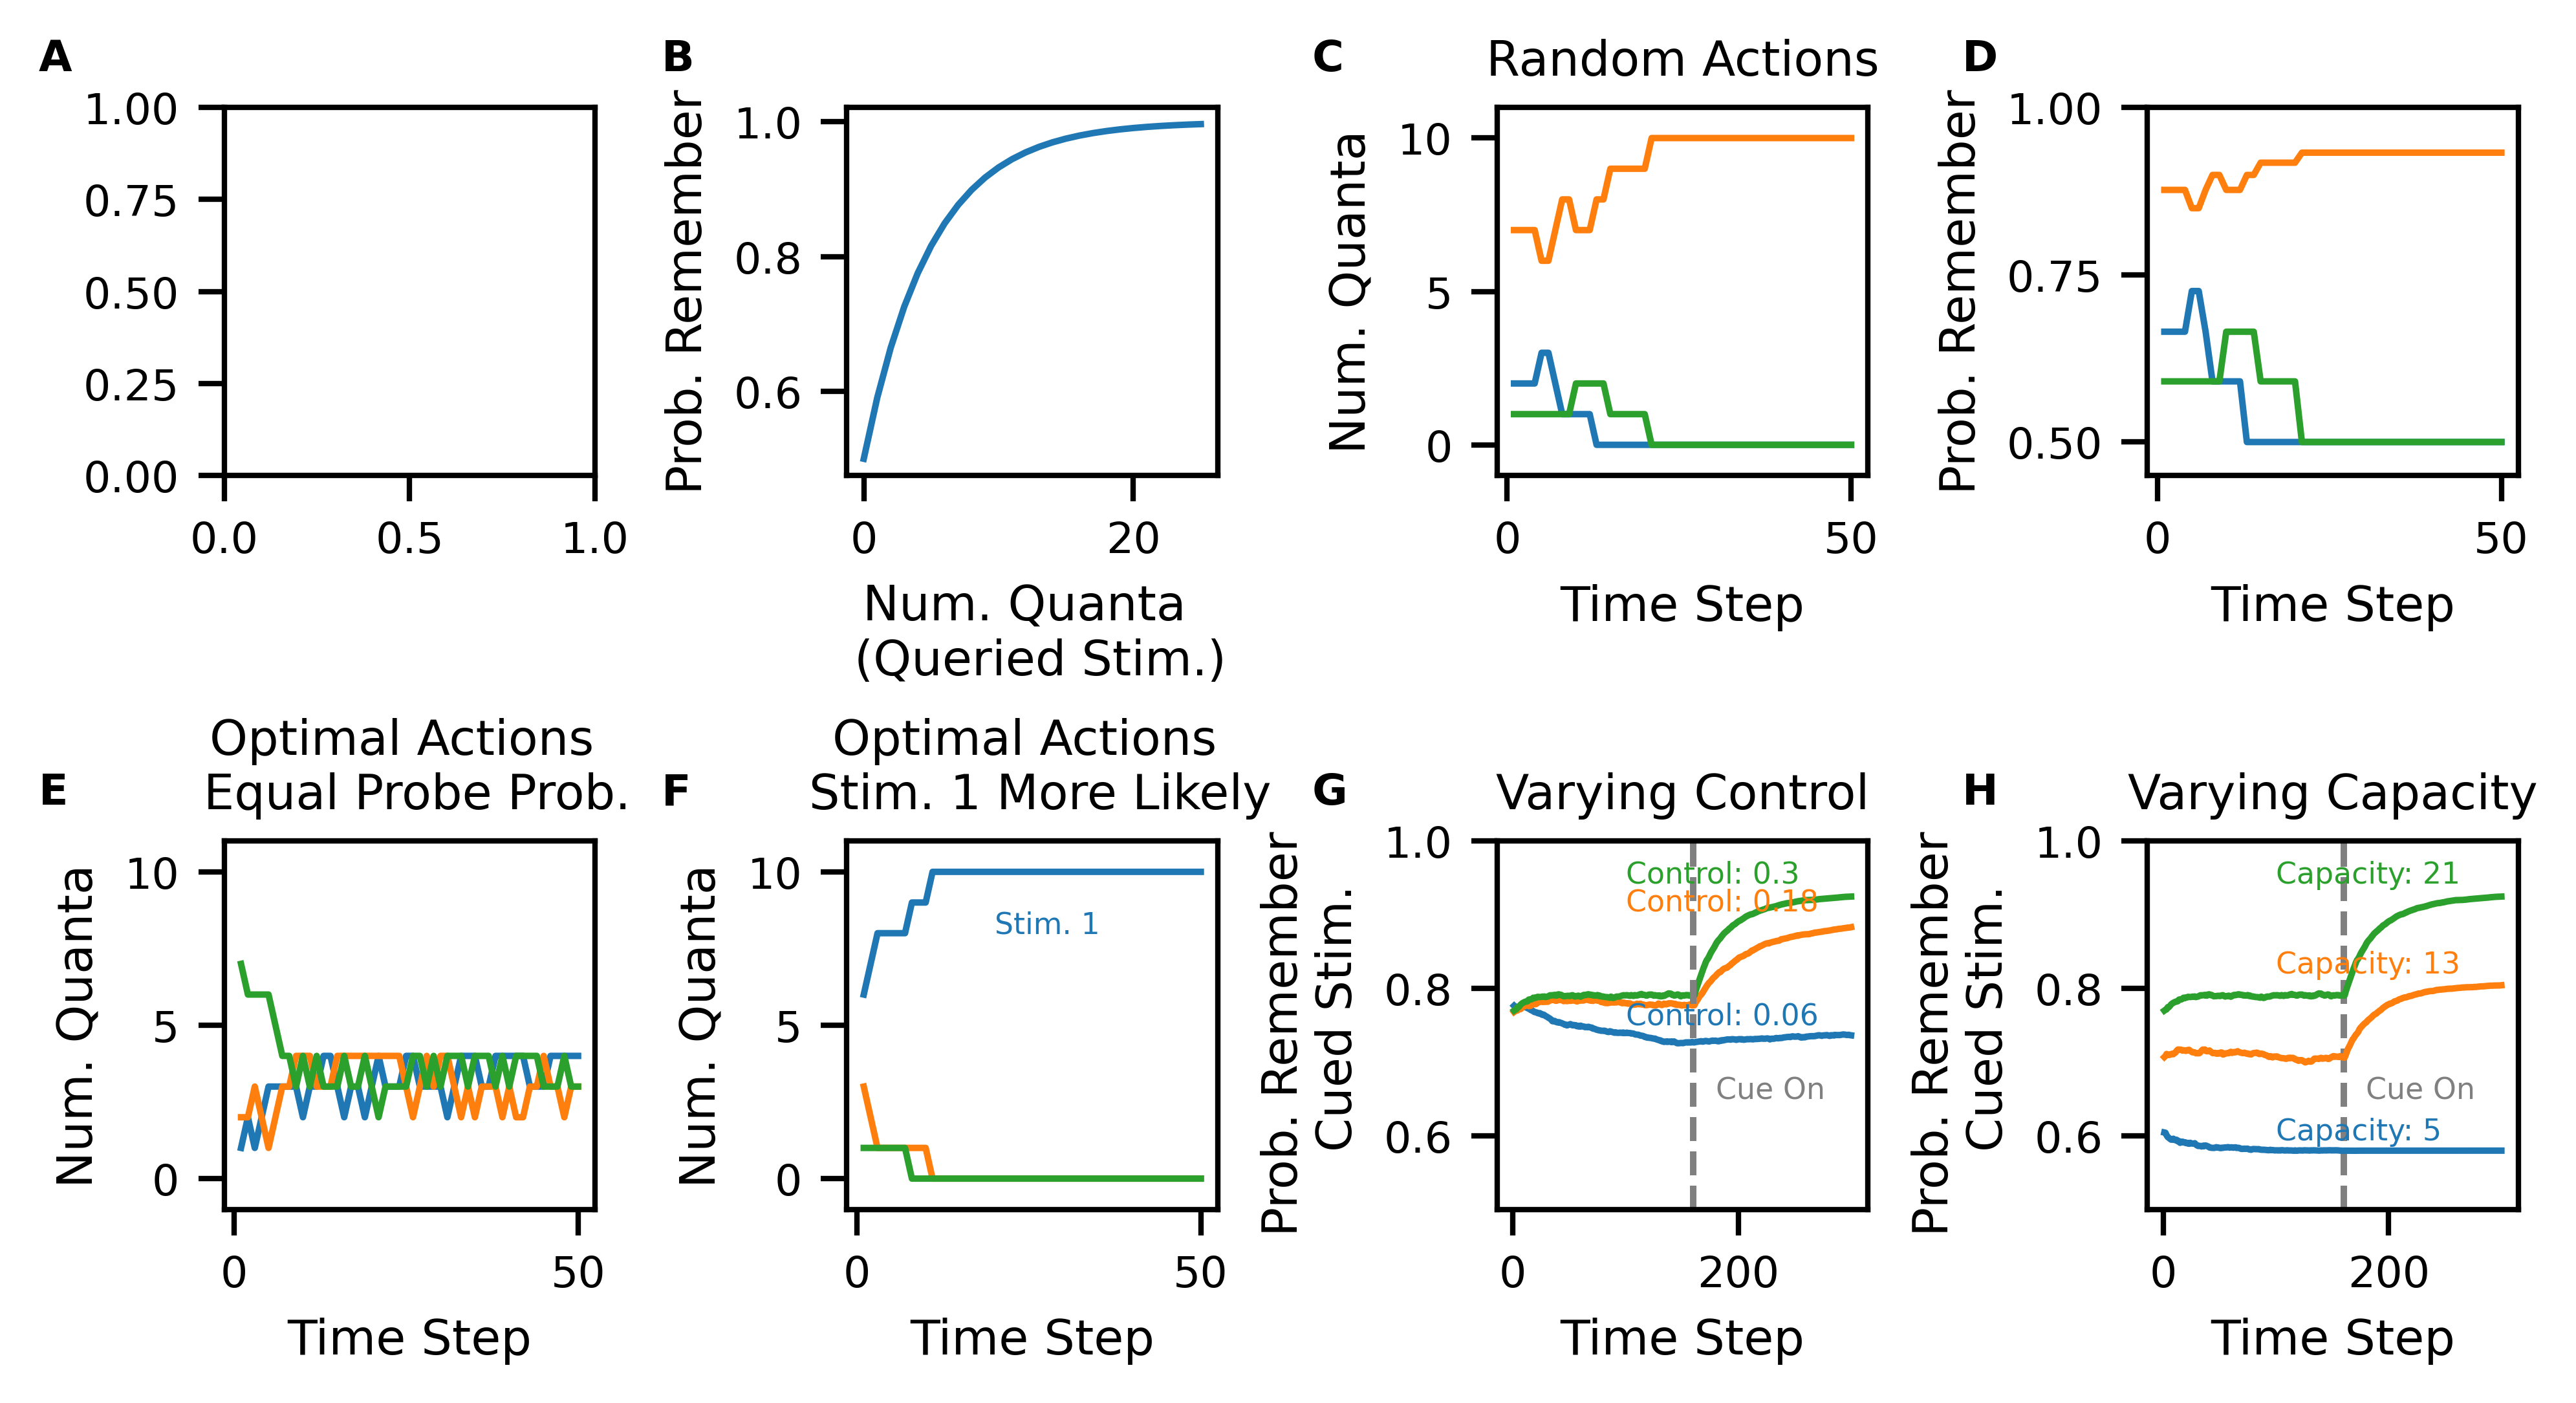

Python: None

In [63]:
mem_slope = .2

TS_show = 50

# plot the memory function over quanta
fig,ax = subplots(2,4, dpi=600, figsize=(6.5,3.5), constrained_layout=true)

# memory function 
ax[0,1].plot(0:25, prob_remember.(0:25; mem_slope = .2))
ax[0,1].set_ylabel("Prob. Remember")
ax[0,1].set_xlabel("Num. Quanta \n (Queried Stim.)")

# random actions - quanta
for obj_idx = 1:3
    ax[0,2].plot((1:N_TimeSteps)[1:TS_show], state_history_random[1:TS_show,obj_idx], label = "Stim. $(obj_idx)")
end

ax[0,2].set_ylabel("Num. Quanta")
ax[0,2].set_xlabel("Time Step")
ax[0,2].set_title("Random Actions")
ax[0,2].set_ylim(-1,11)



# random actions - prob. remember
for obj_idx = 1:3
    ax[0,3].plot((1:N_TimeSteps)[1:TS_show], prob_remember(state_history_random[1:TS_show,obj_idx], mem_slope = .2), label = "Stim. $(obj_idx)")
end

ax[0,3].set_ylim(.45,1)
ax[0,3].set_yticks([.5, .75, 1])
ax[0,3].set_ylabel("Prob. Remember")
ax[0,3].set_xlabel("Time Step")
# ax[0,3].legend(loc= (.5,.25))

# optimal actions / equal probe probs
for obj_idx = 1:3
    ax[1,0].plot(1:TS_show, state_history_op_equal[1:TS_show,obj_idx], label = "Stim. $(obj_idx)")
end

ax[1,0].set_ylabel("Num. Quanta")
ax[1,0].set_xlabel("Time Step")
ax[1,0].set_xlabel("Time Step")
ax[1,0].set_ylim(-1,11)
ax[1,0].set_title("Optimal Actions \n Equal Probe Prob.")

#=
for obj_idx = 1:3
    ax[1,1].plot(1:TS_show, prob_remember.(state_history_op_equal[1:TS_show,obj_idx], mem_slope = .2), label = "Stim. $(obj_idx)")
end

ax[1,1].set_ylabel("Prob. Remember")
ax[1,1].set_xlabel("Time Step")
ax[1,1].set_xlabel("Time Step")
ax[1,1].set_ylim(.45,1)

ax[1,0].set_title("Optimal Actions - Equal Probe Prob.")
=#

# optimal actions / equal probe probs
for obj_idx = 1:3
    ax[1,1].plot(1:TS_show, state_history_op_unequal[1:TS_show,obj_idx], label = "Stim. $(obj_idx)")
end

ax[1,1].text(20,8, "Stim. 1", color = "C0", fontsize = 5.5)

ax[1,1].set_ylabel("Num. Quanta")
ax[1,1].set_xlabel("Time Step")
ax[1,1].set_xlabel("Time Step")
ax[1,1].set_ylim(-1,11)
ax[1,1].set_title("Optimal Actions \n Stim. 1 More Likely")

#### Now, give some sims of retro - cue -  varying 

NT_per_Second = 800
cue_time_step = Int(200* NT_per_Second/1000)
ax[1,2].vlines([cue_time_step], ymin = .5, ymax = 1, color = "gray", ls = "--")

for (this_idx, eps_idx) in enumerate(4:6:19)
    
    epsilon = eps_vals[eps_idx]
    N_Quanta = model_info["Share_Q"]["Child_Q"]
    NT_per_Second = 800

    (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    N_TimeSteps = length(p_short_retro)
    ax[1,2].plot((1:N_TimeSteps)[1:300], p_short_retro[1:300], label = "epsilon", color = "C$(this_idx-1)")
    control = round(1 - epsilon, digits = 2)
    ax[1,2].text(400 - 300, p_short_retro[400] +.015, "Control: $(control)", fontsize = 5.5, color = "C$(this_idx-1)" )
    
end

ax[1,2].text(cue_time_step + 20,.65 , "Cue On", fontsize = 5.5, color = "gray" )
ax[1,2].set_ylim(.5,1)
ax[1,2].set_ylabel("Prob. Remember \n Cued Stim.")
ax[1,2].vlines([cue_time_step], ymin = .5, ymax = 1, color = "gray", ls = "--")
ax[1,2].set_xlabel("Time Step")
ax[1,2].set_title("Varying Control")


ax[1,3].vlines([cue_time_step], ymin = .5, ymax = 1, color = "gray", ls = "--")

for (this_idx,q_idx) = enumerate(4:8:20)
    epsilon = model_info["Share_Eps"]["Child_Eps"]
    N_Quanta = q_vals[q_idx]
    NT_per_Second = 800 # adjust this...

    (p_short_neutral, p_short_retro, p_long_neutral, p_long_retro) = load_results(epsilon, N_Quanta, NT_per_Second, mem_slope; exp_num = 2, on_cluster = false)
    N_TimeSteps = length(p_short_retro)
    cue_time_step = Int(200*NT_per_Second/1000)
    ax[1,3].plot((1:N_TimeSteps)[1:300], p_short_retro[1:300], label = "epsilon")
    
    ax[1,3].text(400 - 300, p_short_retro[400] +.015, "Capacity: $(N_Quanta)", fontsize = 5.5,color = "C$(this_idx-1)" )

end

ax[1,3].set_ylim(.5,1)
ax[1,3].text(cue_time_step + 20,.65 , "Cue On", fontsize = 5.5, color = "gray" )
ax[1,3].set_xlabel("Time Step")
ax[1,3].set_ylabel("Prob. Remember \n Cued Stim.")
ax[1,3].set_title("Varying Capacity")

these_labels = [["A", "B", "C", "D"], ["E", "F", "G", "H"]]
for r_idx = 0:1
    for c_idx = 0:3
        ax[r_idx,c_idx].text(-.5, 1.1, these_labels[r_idx+1][c_idx+1], transform = ax[r_idx,c_idx].transAxes, weight = "bold")    
    end
end

savefig("Cog_Sci_Plots/Model_Explained.svg", format = "svg", bbox_inches="tight")
savefig("Cog_Sci_Plots/Model_Explained.png", format = "png", bbox_inches="tight")

In [17]:
display(model_info["Share_Eps"])

Dict{Any, Any} with 7 entries:
  "Child_Eps" => 0.55
  "Child_Q"   => 10.0
  "Child_MSE" => 0.549677
  "Adult_MSE" => 1.13041
  "Adult_Q"   => 22.0
  "Adult_Eps" => 0.55
  "Both_MSE"  => 1.68009

In [20]:
display(model_info["Share_Q"])

Dict{Any, Any} with 7 entries:
  "Child_Eps" => 0.95
  "Child_Q"   => 24
  "Child_MSE" => 0.719405
  "Adult_MSE" => 1.00441
  "Adult_Q"   => 24
  "Adult_Eps" => 0.61
  "Both_MSE"  => 1.72381